# ML Reglas de Precio

Objetivo: Identificar características importantes para asignación de reglas de precio e incremento de Ingresos (Estimated Revenue)

Variables disponibles cualitativas:  
    - Día (Day)CONFIGURABLE  
    - Día de la semana (Weekday)  
    - Sitio (Site) CONFIGURABLE  
    - Tamaño de creativo (Creative Size) CONFIGURABLE  
    - Dispositivo (Device category) CONFIGURABLE  
    - País (Country) CONFIGURABLE  
    - Nombre Regla de Precio (pricing rule name)

Variables disponibles cuantitativas:  
    - Regla de Precio
    - Ad Requests.  
    - Matched Requests.  
    - Clicks.  
    - Estimated Revenue  
    - Ad Impressions  
    - Active View Enabled Impressions  
    - Active View measured Impressions  
    
$$eCPM = \frac{Ingresos}{Impresiones Vendidas} * 1000$$  
$$Fill Rate = \frac{Impresiones Vendidas}{Oportunidades}$$  
$$rCPM = \frac{Ingresos}{Oportunidades} * 1000 = eCPM * Fill Rate$$  
$$Viewability = \frac{Impresiones Vistas}{Impresiones Disponibles} * 1000$$

Target: Maximizar ingresos (revenue)  
Inputs: weekday, site, creative_size, device_category, country.  
Output: Regla de Precio.

In [186]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [187]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20
    
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

In [169]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

In [170]:
# Función para carga de archivo
import os
import tarfile
import urllib.request
import pandas as pd

PRULES_PATH = os.path.join("datasets")

def load_prules_data(prules_path=PRULES_PATH,filename="newbase_pricing_rules_open.csv"):
    csv_path = os.path.join(prules_path, filename)
    return pd.read_csv(csv_path)

# Definición de funciones

In [188]:

# Clase para añadir atributos combinados al set

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, y=None): # no *args or **kwargs
        self # nothing else to do
    def fit(self, X, y=None):
        return self  # nothing else to do
    # def transform(self, X, bycat=['creative_size', 'weekday', 'site', 'device', 'country'], metric='ad_requests', y=None):
    def transform(self, X, y=None):
        #X = X[(X['active_view_measured_impressions']>0) & (X['ad_requests']>0)]
        X = X[(X['ad_requests']>0)]
        X['rCPM'] = X['revenue']/X['ad_requests']*1000 # Añade rCPM al set
        X['FillRate'] = X['ad_impressions']/X['ad_requests'] # Añade FillRate al Set
        X['eCPM'] = X['revenue']/X['ad_impressions']*1000 # Añade eCPM al set
        #X['Viewability'] = X['active_view_viewed_impressions']/X['active_view_enabled_impressions'] # Añade Viewability al set IGUAL HACERLO EN PROMEDIO.
        
        # Para añadir promedio de Ad Requests
        Xgb = X.groupby(by=['weekday', 'creative_size', 'device', 'country'],group_keys=True).mean()
        meanbycats = Xgb['ad_requests']
        X['aux'] = X['weekday']+X['creative_size']+X['device']+X['country']
        X['avg_ad_requests'] = 0
        X['avg_viewed_impressions'] = 0
        X['avg_enabled_impressions'] = 0
        # Agrega Ad Requests Promedio
        for i, v in meanbycats.items():
            X.loc[X['aux'] == ''.join(i), 'avg_ad_requests'] = v
        
        # Para cálculo de Viewability ponderado
        
        # Agrega Viewed Impressions
        meanbycats = Xgb['active_view_viewed_impressions']    
        for i, v in meanbycats.items():
            X.loc[X['aux'] == ''.join(i), 'avg_viewed_impressions'] = v   
        # Agrega Enabled Impressions
        meanbycats = Xgb['active_view_enabled_impressions']    
        for i, v in meanbycats.items():
            X.loc[X['aux'] == ''.join(i), 'avg_enabled_impressions'] = v    
            
        X['Viewability_pond'] = X['avg_viewed_impressions']/X['avg_enabled_impressions'] # División Viewability pond
        
        # Eliminar campos auxiliares
        X = X.drop(['aux','avg_viewed_impressions','avg_enabled_impressions'], axis=1)
        return X

In [189]:

# (Estrategia 1) Función para definir si la instancia entrada tiene eCPM superior al eCPM general 

def categorise(row,dfgb,porc):
    cpm_inst = row['rCPM'] # Se obtiene el CPM de la instancia
    c_size = row['creative_size'] # Se obtiene el creative_size de la instancia
    cpm_pond = (dfgb.loc[c_size]['revenue']/dfgb.loc[c_size]['ad_requests']*1000) # Se obtiene el CPM general del creative size
    
    if cpm_inst > cpm_pond*(1+porc): # Se compara cpm de la instancia vs cpm general del creative size
        return 1
    else:
        return 0 

In [191]:

# Clase para filtrar instancias que cumplan con CPM superior a la media y fill rate

class StrategyCPMSuperior(BaseEstimator, TransformerMixin):
    def __init__(self, porc=0, fill_rate=.60, limit_cpm=150): # no *args or **kwargs
        self.porc = porc
        self.fill_rate = fill_rate
        self.limit_cpm = limit_cpm
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        Xgb = X.groupby('creative_size').sum() # Se crea matriz para cálculo de eCPM general
        X['flag_cpm_sup'] = X.apply(lambda row: categorise(row,Xgb,self.porc), axis=1) # Se añade columna con flag 0-1 para determinar si cumple con criterio
        X = X[(X['FillRate']>self.fill_rate) & ((X['flag_cpm_sup']==1) & (X['rCPM']<self.limit_cpm))] # Se filtran instancias que cumplan con criterios.
        X = X.reset_index(drop = True) # Resetea index para evitar errores posteriormente
        return X

In [192]:

# (Estrategia 2) Función para definir si la instancia entrada es real_pricing > floor_pricing

def categorise_pricing(row,porc):
    if row['ad_impressions'] > 0: # Condicional para evitar indeterminación en división de métrica real_pricing
        real_pricing = row['revenue']/row['ad_impressions'] # Se obtiene métrica real_pricing
        floor_pricing = row['pricing_rules']*row['ad_impressions']/1000000 # Se obtiene métrica real_pricing
    else:
        real_pricing = 0
        floor_pricing = 0
    
    if real_pricing > floor_pricing*(1+porc): # Se compara real pricing con floor pricing, con un % mínimo
        return 1
    else:
        return 0 

In [201]:

# Clase para filtrar instancias que cumplan con real_pricing > floor_pricing y fill rate

class StrategyRealvsFloorPricing(BaseEstimator, TransformerMixin):
    def __init__(self, porc=0, fill_rate=.60, limit_cpm=150): # no *args or **kwargs
        self.porc = porc
        self.fill_rate = fill_rate
        self.limit_cpm = limit_cpm
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        X['flag_pricing_sup'] = X.apply(lambda row: categorise_pricing(row,self.porc), axis=1) # Se añade columna con flag 0-1 para determinar si cumple con criterio
        X = X[(X['FillRate']>self.fill_rate) & (X['FillRate']<=1) & (X['flag_pricing_sup']==1) & (X['eCPM']<self.limit_cpm)] # Se filtran instancias que cumplan con criterios.>
        X = X.reset_index(drop = True) # Resetea index para evitar errores posteriormente
        return X

In [194]:

# Clase para estratificar por regla de precio y dividir en set de entrenamiento y set de validación

class Strat_sets(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kwargs
        self # nothing else to do
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        #X["pr_cat"] = pd.cut(X["weekday"],
        #                       bins=['jue', 'vie', 'sáb', 'dom', 'mar', 'lun', 'mié'],
        #                       labels=[1, 2, 3, 4, 5])
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
        for train_index, test_index in split.split(X, X["weekday"]): # Estratificado de set.
            X_train_set = X.loc[train_index]
            X_test_set = X.loc[test_index]
        return X_train_set, X_test_set

In [195]:
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
# REVISAR SI EXISTE OTRO DATAFRAMESELECTOR NUEVO Y PONERLO ARRIBA PARA USARLO EN ERRORES DE VISUALIZACIÓN DE .HEAD().

In [196]:
num_attribs = ['Viewability_pond', 'avg_ad_requests', 'pricing_rules']
cat_attribs = ['weekday', 'creative_size', 'device', 'country']



old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),# REVISAR DOCUMENTACIÓN DE SIMPLEIMPUTER
        ('std_scaler', StandardScaler()),# DIFERENTES MEDIAS
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [197]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [154]:
from sklearn.preprocessing import PolynomialFeatures

In [155]:
def plot_learning_curves(model, X, y, XTest, yTest): # Entradas sean los sets que ya se aplicó shuffle
    X_train = X
    X_val = XTest
    y_train = y
    y_val = yTest
    train_errors, val_errors = [], []
    #for m in range(1, len(X_train)):
    for m in range(1, 1800):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict)) # 
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    print("Last train error: "+ str(np.sqrt(train_errors[-1])))
    print("Last valid error: "+ str(np.sqrt(val_errors[-1])))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

# Pipelines

### Pipeline estrategia 1

In [178]:
# PARA PRIMERAS PRUEBAS Y ANÁLISIS DE COMPORTAMIENTO, TOMAMOS SOLAMENTE INFORMACIÓN DE EXCÉLSIOR.
# Visualización de la carga
target_site = 'Excelsior'

carga_prules = pd.concat([load_prules_data(filename="pt1_newbase_pricing_rules_open.csv"),load_prules_data(filename="pt2_newbase_pricing_rules_open.csv")])

prules = carga_prules[carga_prules['site'] == target_site]
prulesorg = carga_prules[carga_prules['site'] == target_site]

In [202]:
# Pipeline para limpieza de los datos de estrategia CPM

bycatl = ['creative_size', 'weekday', 'site', 'device', 'country']
target='rCPM'

clean_cpm_pipeline = clean_realp_pipeline = Pipeline([
        ('attribs_adder', CombinedAttributesAdder()),
        ('strategy_cpm', StrategyCPMSuperior(porc=.10,fill_rate=.60,limit_cpm=150)),
        ('stratified',Strat_sets()),
])

cpm_train, cpm_test = clean_cpm_pipeline.transform(prulesorg)
# Se asignan etiquetas para set de training
cpm_analysis = cpm_train.copy()
cpm_labels = cpm_train[target].copy()
cpm_train = cpm_train.drop(target, axis=1) # drop labels for training set


# Se asignan etiquetas para set de testing
cpm_test_labels = cpm_test[target].copy()
cpm_test = cpm_test.drop(target, axis=1)

# GENERAR ETIQUETAS DE TESTING

C:\Users\Aaron\AppData\Local\Temp\ipykernel_9196\652659513.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rCPM'] = X['revenue']/X['ad_requests']*1000 # Añade rCPM al set
C:\Users\Aaron\AppData\Local\Temp\ipykernel_9196\652659513.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FillRate'] = X['ad_impressions']/X['ad_requests'] # Añade FillRate al Set
C:\Users\Aaron\AppData\Local\Temp\ipykernel_9196\652659513.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [203]:
cpm_analysis.describe()

,pricing_rules,ad_requests,matched_ad_requests,clicks,revenue,ad_impressions,active_view_enabled_impressions,active_view_measured_impressions,active_view_viewed_impressions,rCPM,FillRate,eCPM,avg_ad_requests,Viewability_pond,flag_cpm_sup
count,11765.000000,11765.000000,11765.000000,11765.000000,11765.000000,11765.000000,11765.000000,11765.000000,11765.000000,11765.000000,11765.000000,11765.000000,11765.000000,11765.000000,11765.0
mean,2.827614,9923.934382,8613.905737,56.525457,54.782971,7419.735572,7394.888568,7376.692138,5161.422524,16.111642,0.792867,19.952228,7025.116098,0.686131,1.0
std,1.614170,43729.241196,39297.996957,353.739078,227.671766,33265.487949,33151.296400,33070.865856,21671.119036,20.252909,0.170067,23.928082,13757.948330,0.149356,0.0
min,0.450000,1.000000,0.000000,0.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.597134,0.600100,0.833333,1.111111,0.000000,1.0
25%,1.600000,8.000000,7.000000,0.000000,0.090000,6.000000,6.000000,6.000000,3.000000,4.822547,0.666667,6.136112,401.205781,0.573485,1.0
50%,2.600000,56.000000,47.000000,0.000000,0.560000,41.000000,41.000000,41.000000,28.000000,9.097222,0.758798,10.867734,1297.433841,0.683492,1.0
75%,3.100000,1003.000000,815.000000,2.000000,8.260000,710.000000,707.000000,705.000000,559.000000,18.791859,0.892388,23.888889,7111.544503,0.803584,1.0
max,8.500000,757734.000000,682348.000000,9934.000000,4490.650000,549722.000000,548985.000000,547417.000000,379007.000000,148.750000,6.333333,234.117647,116162.175781,0.976303,1.0


Saving figure scatter_matrix_plot


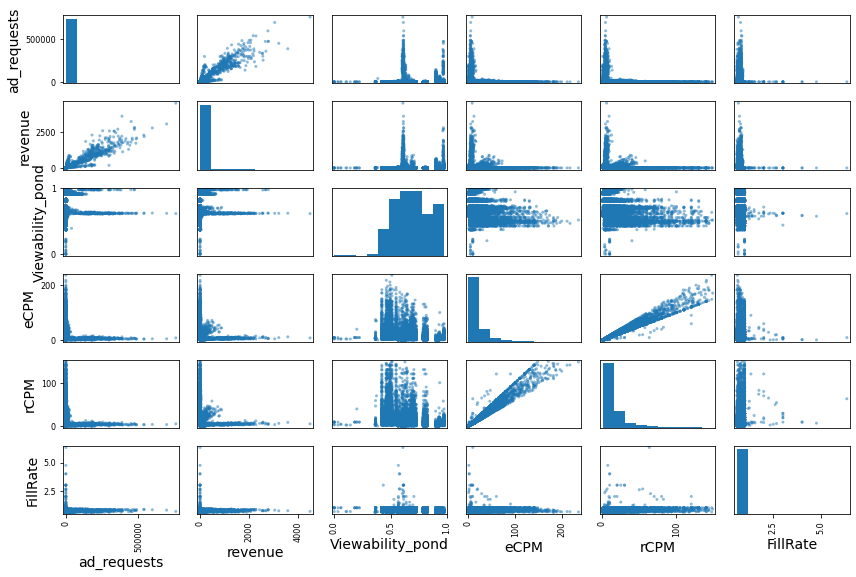

In [200]:
from pandas.plotting import scatter_matrix

attributes = ["ad_requests", "revenue",'Viewability_pond',
              "eCPM", 'rCPM', 'FillRate']
scatter_matrix(cpm_analysis[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [184]:
cpm_prepared = full_pipeline.fit_transform(cpm_train)
cpmTest_prepared = full_pipeline.fit_transform(cpm_test)

Last train error: 17.497769436893943
Last valid error: 17.717319544050515


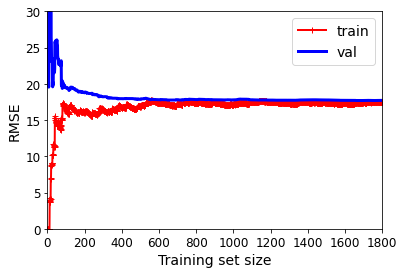

In [185]:

# Curvas de aprendizaje de modelo lineal

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
#lin_reg.fit(cpm_prepared, cpm_labels)

plot_learning_curves(lin_reg, cpm_prepared, cpm_labels, cpmTest_prepared, cpm_test_labels)
plt.axis([0, 1800, 0, 30])                         # not shown in the book
plt.show()

In [79]:
# Con set completo baja a 

from sklearn.metrics import mean_squared_error

cpm_predictions = lin_reg.predict(cpm_prepared)
lin_mse = mean_squared_error(cpm_labels, cpm_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

17.502132679340928

Last train error: 11.558603175522112
Last valid error: 20.75429232675397


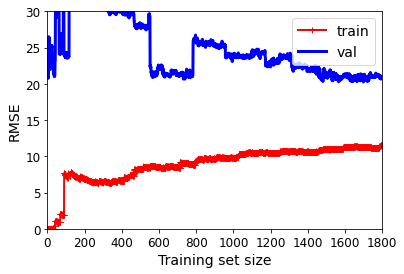

In [75]:

# Curvas de aprendizaje de modelo Arbol de Decisión

## Arbol de decisiones
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
#tree_reg.fit(cpm_prepared, cpm_labels)

plot_learning_curves(tree_reg, cpm_prepared, cpm_labels, cpmTest_prepared, cpm_test_labels)
plt.axis([0, 1800, 0, 30])                         # not shown in the book
plt.show()

In [ ]:

# Curvas de aprendizaje de modelo Arbol de Decisión

## Arbol de decisiones
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
#tree_reg.fit(cpm_prepared, cpm_labels)

plot_learning_curves(tree_reg, cpm_prepared, cpm_labels, cpmTest_prepared, cpm_test_labels)
plt.axis([0, 1800, 0, 30])                         # not shown in the book
plt.show()

Last train error: 19.074492643826602
Last valid error: 18.179828292829033


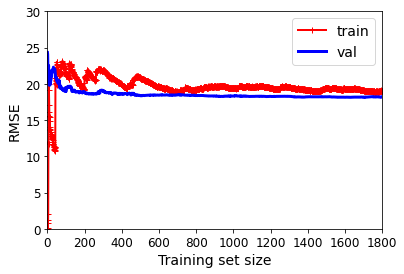

In [65]:
# Curvas de aprendizaje de modelo SVM

## SVM
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
#svm_reg.fit(cpm_prepared, cpm_labels)

plot_learning_curves(svm_reg, cpm_prepared, cpm_labels, cpmTest_prepared, cpm_test_labels)
plt.axis([0, 1800, 0, 30])                         # not shown in the book
plt.show()

### Pipeline Estrategia 2

In [80]:
clean_realp_pipeline = Pipeline([
        ('attribs_adder', CombinedAttributesAdder()),
        ('strategy_realp', StrategyRealvsFloorPricing(porc=.30,fill_rate=.60,limit_cpm=150)),
        ('stratified',Strat_sets()),
])

realp_train, realp_test = clean_realp_pipeline.transform(prulesorg)
# Se asignan etiquetas para set de training
realp = realp_train.drop(target, axis=1) # drop labels for training set
realp_labels = realp_train[target].copy()

# Se asignan etiquetas para set de testing
realp_test_labels = realp_test[target].copy()
realp_test = realp_test.drop(target, axis=1)

# GENERAR ETIQUETAS DE TESTING

C:\Users\Aaron\AppData\Local\Temp\ipykernel_9196\395035628.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rCPM'] = X['revenue']/X['ad_requests']*1000 # Añade rCPM al set
C:\Users\Aaron\AppData\Local\Temp\ipykernel_9196\395035628.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FillRate'] = X['ad_impressions']/X['ad_requests'] # Añade FillRate al Set
C:\Users\Aaron\AppData\Local\Temp\ipykernel_9196\395035628.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [81]:
realp_prepared = full_pipeline.fit_transform(realp)
realpTest_prepared = full_pipeline.fit_transform(realp_test)

Last train error: 16.322561024001192
Last valid error: 16.588211229513938


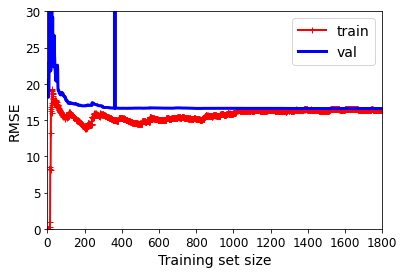

In [82]:

# Curvas de aprendizaje de modelo lineal

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
#lin_reg.fit(realp_prepared, realpTest_labels)

plot_learning_curves(lin_reg, realp_prepared, realp_labels, realpTest_prepared, realp_test_labels)
plt.axis([0, 1800, 0, 30])                         # not shown in the book
plt.show()

Last train error: 10.53947220665601
Last valid error: 19.562512417134467


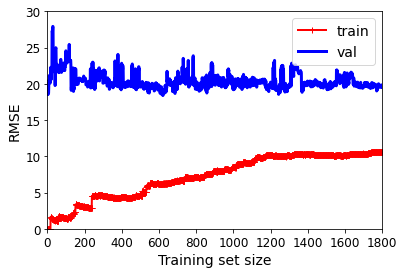

In [60]:

# Curvas de aprendizaje de modelo Arbol de Decisión

## Arbol de decisiones
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
#tree_reg.fit(cpm_prepared, cpm_labels)

plot_learning_curves(tree_reg, realp_prepared, realp_labels, realpTest_prepared, realp_test_labels)
plt.axis([0, 1800, 0, 30])                         # not shown in the book
plt.show()

Last train error: 17.645231399214858
Last valid error: 17.83069174179232


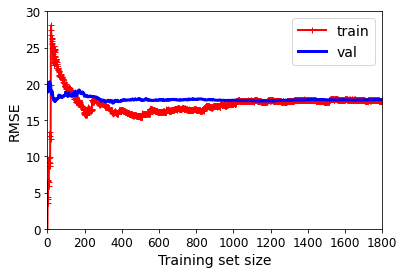

In [61]:
# Curvas de aprendizaje de modelo SVM

## SVM
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
#svm_reg.fit(cpm_prepared, cpm_labels)

plot_learning_curves(svm_reg, realp_prepared, realp_labels, realpTest_prepared, realp_test_labels)
plt.axis([0, 1800, 0, 30])                         # not shown in the book
plt.show()

Last train error: 14.958560762845666
Last valid error: 41508552814.28591


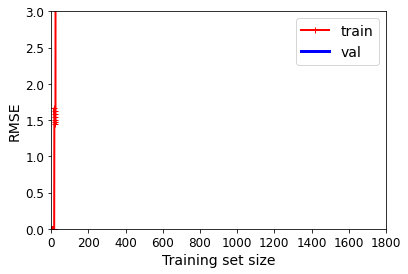

In [62]:

# Curvas de aprendizaje de polinomial grado 2

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, realp_prepared, realp_labels, realpTest_prepared, realp_test_labels)
plt.axis([0, 1800, 0, 3])                         # not shown in the book
plt.show()

In [ ]:
# Análisis estadístico de etiquetas (rCPM) comportamientos.
# Buscar etiquetas con menos dispersión.
